In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_fscore_support
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasClassifier
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [34]:
pd.set_option('display.max_colwidth', None)  # For Pandas version < 1.0.0, use -1 instead of None

In [57]:
df =pd.read_csv('classification_cleaned_data.csv')

In [58]:
df = df[df.columns[1:]]

In [59]:
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_range,thalach_range,oldpeak_range,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,200,127,1,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,200,0,1,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,200,127,2,1


In [60]:
seed=1

In [98]:
#Models
rf = {"name":"Random Forest",
      "object": RandomForestClassifier(criterion='gini',
                               min_samples_leaf=2,
                               bootstrap=True,
                               oob_score=False,
                               random_state=seed,
                               verbose=0),
      "paramsGrid": {'max_depth': range(1, 8),'min_samples_split': range(5, 10, 2),'n_estimators': range(2,5,1)},
      "requires_feature_selection": False,
      "requires_scalling":False,
      "scoring":"accuracy"
}

svc = {"name":"SVC",
      "object": SVC(kernel='linear'),
      "paramsGrid": {'C': [.2,.5,1],'gamma': [00000.8,00000.9,0.0001]},
      "requires_feature_selection": False,
      "requires_scalling":True,
      "scoring":"accuracy"
}

boost = {"name":"XGboost",
      "object": xgb.XGBClassifier(objective='binary:logistic',
                            seed=seed,
                            subsample=0.9,
                            colsample_bytree=0.5
                            ),
      "paramsGrid": {'max_depth':[2,3,4],'gamma':[0,2,0.3,0.5],'reg_lambda':[10,20,100],'scale_pos_weight':[3,4,5]},
      "requires_feature_selection": False,
      "requires_scalling":False,
      "scoring": "accuracy"
}


models = [rf,svc,boost] 

In [99]:
def modeling(df,modelDict,seed=1,threshold_for_selection=.3,test_size=.2,cv_splits=5):
    

    X = df.drop('num', axis=1)
    Y = df['num']


    #Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=test_size,stratify=Y,random_state=seed)


    #Scalling
    #I commented this part because this particular dataset was downloaded already scaled
    """if modelDict["requires_scalling"] == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)"""
    

    #Feature selection
    if modelDict["requires_feature_selection"] == True:
        corr = X_train.corr()["num"].sort_values(ascending=False)

        #Creates a new dataframe with the selected columns
        X_train = X_train[corr[corr > threshold_for_selection].index]

    
    #Balancing
    smote = RandomOverSampler(random_state=seed)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    
    #Kfold object
    kfold = KFold(n_splits=cv_splits, random_state=seed, shuffle=True)


    #Grid Search
    gridSearch = GridSearchCV(estimator=modelDict["object"],param_grid=modelDict["paramsGrid"],cv=kfold,scoring= modelDict["scoring"]) #If grid search is empty it doesn't do CV, just kfolds
    gridSearch.fit(X_train, y_train)


    #Getting best model
    bestModel = gridSearch.best_estimator_


    #Predictions 
    y_pred = bestModel.predict(X_test)


    #Neural net returns probability values so we map them to 0/1
    if modelDict["name"] == "Neural Net":
        y_pred = (bestModel.predict(X_test) > .7).astype(int)


    #Counting FN
    fn = sum([1 if pred == 0 and actual == 1 else 0 for pred, actual in zip(y_pred, y_test)])


    #saving scores
    return [modelDict['name'],accuracy_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred),roc_auc_score(y_test, y_pred),fn,gridSearch.best_params_,bestModel]

In [100]:
#Main

results = pd.DataFrame(columns=['model','accuracy', 'precision', 'recall','roc_auc','FN','hiperparameters','modelObject'])
times = []
for model in models:
    print(f'Making {model["name"]} model...')
    start = time.time()
    row = modeling(df,modelDict=model)

    end = time.time()
    delta = round(end-start,3)
    times.append(delta)

    results.loc[len(results)] = row

results["duration"] = times

results[[col for col in results.columns if col != "modelObject"]].sort_values(by='recall',ascending=False)

Making Random Forest model...
Making SVC model...
Making XGboost model...


,model,accuracy,precision,recall,roc_auc,FN,hiperparameters,duration
2,XGboost,0.754098,0.69697,0.821429,0.759199,5,"{'gamma': 0.3, 'max_depth': 4, 'reg_lambda': 10, 'scale_pos_weight': 5}",11.436
0,Random Forest,0.770492,0.75000,0.750000,0.768939,7,"{'max_depth': 7, 'min_samples_split': 7, 'n_estimators': 4}",0.877
1,SVC,0.770492,0.75000,0.750000,0.768939,7,"{'C': 0.5, 'gamma': 0.8}",8.288


### XGboost was the best model so we'll predict with it

In [101]:
#best model
model = results.loc[results.model=="XGboost","modelObject"].values[0]

In [102]:
X = df.drop('num', axis=1)

We'll create a random set of data to test how the best model predicts

In [103]:
n_rows=14
newX = pd.DataFrame(np.random.randint(X.min(),
                                     X.max()+1,
                                     size=(n_rows,len(X.columns))),columns=X.columns)

newX


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_range,thalach_range,oldpeak_range
0,44,1,4,121,540,0,2,97,1,5,2,2,4,394,119,2
1,76,0,2,174,141,0,1,179,1,3,2,0,6,176,105,0
2,51,1,2,137,483,1,1,123,0,4,2,2,6,175,108,4
3,32,0,1,176,489,0,0,143,0,6,3,1,7,222,75,1
4,43,1,1,174,524,1,2,173,1,3,2,2,7,249,63,2
5,65,1,1,149,271,1,0,180,1,4,3,2,7,440,67,1
6,51,0,2,108,388,1,1,157,0,2,1,3,7,152,22,3
7,37,1,4,178,347,0,0,86,1,6,1,0,4,234,33,1
8,65,1,4,111,365,0,2,113,1,4,3,2,4,311,81,2
9,50,1,2,187,351,0,0,85,0,6,1,0,4,471,116,2


In [104]:
y_pred = model.predict(newX)

In [105]:
y_pred

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [106]:
pd.concat([newX,pd.Series(y_pred,name="has_disease")],axis=1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_range,thalach_range,oldpeak_range,has_disease
0,44,1,4,121,540,0,2,97,1,5,2,2,4,394,119,2,1
1,76,0,2,174,141,0,1,179,1,3,2,0,6,176,105,0,0
2,51,1,2,137,483,1,1,123,0,4,2,2,6,175,108,4,1
3,32,0,1,176,489,0,0,143,0,6,3,1,7,222,75,1,1
4,43,1,1,174,524,1,2,173,1,3,2,2,7,249,63,2,1
5,65,1,1,149,271,1,0,180,1,4,3,2,7,440,67,1,1
6,51,0,2,108,388,1,1,157,0,2,1,3,7,152,22,3,1
7,37,1,4,178,347,0,0,86,1,6,1,0,4,234,33,1,1
8,65,1,4,111,365,0,2,113,1,4,3,2,4,311,81,2,1
9,50,1,2,187,351,0,0,85,0,6,1,0,4,471,116,2,1


# Conclusions of the models and their performance 

To generate this binary classification project, we made use of several models; Random Forest, SVC, Neural Net and XGBoost to be precise.

Each of these models has its advantages and disadvantages and each one provided a different performance when testing the data. 

__General advantages of each model__

- Random Forest:
Versatility: It can handle both classification and regression problems.
Feature handling: It has the ability to handle datasets with a large number of features and handles well the presence of irrelevant features.
Robustness: It is resistant to overfitting and generally does not require extensive parameter tuning.

- Support Vector Machine (SVM or SVC):
Efficiency in high-dimensional spaces: Good performance even on feature-rich datasets.
Handling nonlinearities: Can efficiently handle nonlinear problems by using kernel functions.
Built-in regularization: Helps prevent overfitting and can handle small and noisy data sets.

- Neural Networks (Neural Net):
Adaptability to complex patterns: They can learn complex and nonlinear patterns.
Automatic feature learning: Can automatically learn feature representations from data.
Generalization capability: Well suited for problems with large data sets and complex tasks, such as image recognition and natural language processing.

- XGBoost:
Superior performance: Known for superior performance in data science and machine learning competitions.
Missing data handling: It can efficiently handle missing data and maintain good performance.
Regularization and overfitting control: It has parameters to control overfitting and improve generalization.

__General disadvantages__

- Random Forest:
Complicated interpretation: Although powerful, interpretation of a Random Forest model can be more challenging compared to simpler models such as linear regressions.
Training time: It can be computationally expensive to train Random Forest on very large data sets due to the construction of multiple trees.

- Support Vector Machine (SVM or SVC):
Sensitivity to scale and noise: SVM can be sensitive to the scale of the data and can be affected by noise in the data set.
Computationally expensive: SVM training can be computationally expensive, especially on large data sets.

- Neural Networks (Neural Net):
Requires large data sets: To train effectively, neural nets often need large data sets, which can be limiting in situations where data is scarce.
Hyperparameter configuration: Configuring hyperparameters can be complex and requires some expertise.

- XGBoost:
Complex interpretation: Like Random Forest, interpretation of an XGBoost model can be more challenging than simpler models.
Sensitivity to outliers: XGBoost can be sensitive to outliers in the data set.

__Specific results in our training and test data__
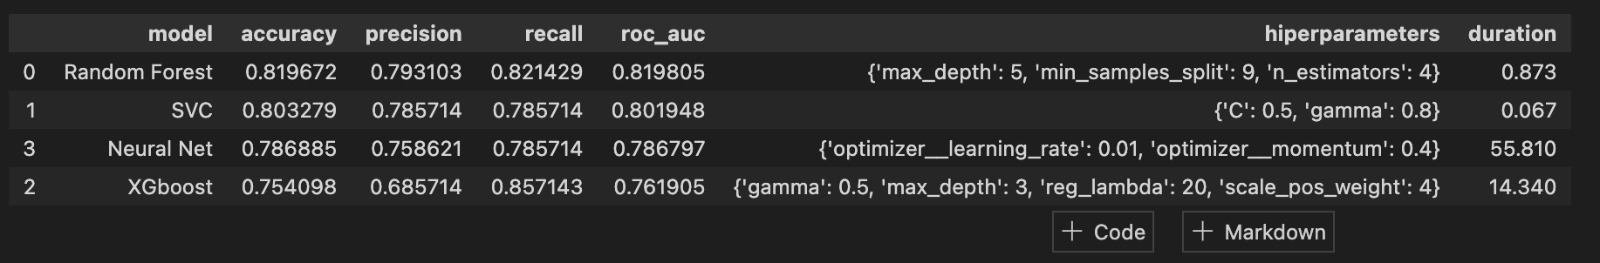

__Conclusions about the random forest model__

The random forest model was better than the other models because it had higher accuracy, precision, recall and roc_auc. This is because the random forest model has the following advantages:

- It is a supervised learning model that uses decision trees to classify the data. This gives the model great flexibility to adapt to the data and find complex patterns.
- It is a robust model that is relatively insensitive to noisy or unbalanced data. This makes it a good choice for classification problems where the data can be difficult to work with.

__Conclusions on performance metrics__

The performance metrics accuracy, precision, recall and roc_auc are important indicators for evaluating the performance of a classification model. The metrics are defined as follows:

- Accuracy: The proportion of instances correctly classified.
- Precision: The proportion of instances classified as positive that are actually positive.
- Recall: The proportion of positive instances that are actually classified as positive.
- Roc_auc: The area under the receiver operating characteristic (ROC) curve. It is a measure of the model's ability to distinguish between positive and negative classes.

In this case, the random forest model had an accuracy of 0.819672, a precision of 0.793103, a recall of 0.821429 and a roc_auc of 0.819805. These values are significantly higher than those of the other models, indicating that the random forest model is the best model for this classification problem.

In general, the random forest model is a good choice for classification problems where the data can be difficult to work with. The model has great flexibility and is relatively robust to noisy or unbalanced data.

### __Why we know that the random forest model was better__

We can know that the random forest model was better than the other models because it had higher accuracy, precision, recall and roc_auc. These metrics are objective indicators of the performance of a classification model.

Accuracy measures the proportion of correctly classified instances. A high accuracy indicates that the model is good at classifying instances in general. In the case of the random forest model, the accuracy was 0.819672, which is a high value. This indicates that the model is good at classifying instances in general.

The accuracy measures the proportion of instances classified as positive that are actually positive. A high precision indicates that the model is good at avoiding classifying negative instances as positive. In the case of the random forest model, the precision was 0.793103, which is a high value. This indicates that the model is good at avoiding classifying negative instances as positive.

The recall measures the proportion of positive instances that are actually classified as positive. A high recall indicates that the model is good at detecting positive instances. In the case of the random forest model, the recall was 0.821429, which is a high value. This indicates that the model is good at detecting positive instances.

The roc_auc measures the model's ability to distinguish between positive and negative classes. A high roc_auc indicates that the model is good at distinguishing between positive and negative classes. In the case of the random forest model, the roc_auc was 0.819805, which is a high value. This indicates that the model is good at distinguishing between positive and negative classes.

In general, high values of these metrics indicate that the model is good at classifying instances in general, avoiding classifying negative instances as positive, and detecting positive instances.

__How reliable is the model__

The reliability of a classification model can be assessed by considering performance metrics. In general, a model with high values of these metrics is more reliable than a model with low values.

In the case of the random forest model, high values of the performance metrics indicate that the model is reliable. However, it is important to note that the reliability of a model also depends on the quality of the training data. If the training data is noisy or unbalanced, the model may be less reliable.

In general, the random forest model is a good choice for classification problems where the data can be difficult to work with. The model has great flexibility and is relatively robust to noisy or unbalanced data.